# Análise Estratégica de Migração para Site Próprio

**Objetivo:** Demonstrar os benefícios estratégicos e financeiros da migração de clientes de outras plataformas (iFood, Rappi, WhatsApp) para o site próprio da Kaiserhaus.

**Foco:** Insights quantitativos que justifiquem o investimento em migração e mostrem o potencial de crescimento e otimização operacional.



In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [28]:
df = pd.read_csv('tratamento_inicial/Base_Kaiserhaus_Limpa.csv')

print(f"Total de pedidos: {len(df):,}")
print(f"Período: {df['order_datetime'].min()} até {df['order_datetime'].max()}")
print(f"Plataformas: {', '.join(df['platform'].unique())}")

# Converter para datetime
df['order_datetime'] = pd.to_datetime(df['order_datetime'])
df['hora'] = df['order_datetime'].dt.hour
df['dia_semana'] = df['order_datetime'].dt.day_name()
df['mes'] = df['order_datetime'].dt.month

def periodo_dia(hora):
    if 0 <= hora < 6:
        return 'Madrugada'
    elif 6 <= hora < 12:
        return 'Manhã'
    elif 12 <= hora < 18:
        return 'Tarde'
    else:
        return 'Noite'

df['periodo_dia'] = df['hora'].apply(periodo_dia)
df['is_pico'] = df['hora'].isin([12, 13, 14, 19, 20])

print(f"\nDistribuição por plataforma:")
print(df['platform'].value_counts())
print(f"\nDistribuição por modo de pedido:")
print(df['order_mode'].value_counts())


Total de pedidos: 5,000
Período: 2024-01-01 15:08:00 até 2024-12-31 21:27:00
Plataformas: rappi, ifood, site_proprio, whatsapp

Distribuição por plataforma:
platform
ifood           2661
site_proprio    1052
rappi            747
whatsapp         540
Name: count, dtype: int64

Distribuição por modo de pedido:
order_mode
delivery    4024
retirada     976
Name: count, dtype: int64


## Análise Comparativa de Performance: Site Próprio vs Outras Plataformas
**Objetivo:** Demonstrar as vantagens operacionais e de qualidade do site próprio.


In [29]:
print("ANÁLISE COMPARATIVA DE PERFORMANCE")

print("Comparando site próprio vs outras plataformas")

site_proprio = df[df['platform'] == 'site_proprio']
outras_plataformas = df[df['platform'] != 'site_proprio']

performance_comparativa = df.groupby('platform').agg({
    'tempo_preparo_minutos': ['count', 'mean', 'std'],
    'actual_delivery_minutes': ['mean', 'std'],
    'eta_minutes_quote': 'mean',
    'satisfacao_nivel': ['mean', 'std'],
    'total_brl': ['mean', 'sum'],
    'platform_commission_pct': 'mean',
    'num_itens': 'mean'
}).round(2)

print("\nPERFORMANCE OPERACIONAL POR PLATAFORMA:")
print(performance_comparativa)

print("\nVANTAGENS DO SITE PRÓPRIO:")
print(f"Tempo médio de entrega: {site_proprio['actual_delivery_minutes'].mean():.1f} min vs {outras_plataformas['actual_delivery_minutes'].mean():.1f} min")
print(f"Satisfação média: {site_proprio['satisfacao_nivel'].mean():.2f} vs {outras_plataformas['satisfacao_nivel'].mean():.2f}")
print(f"Ticket médio: R$ {site_proprio['total_brl'].mean():.2f} vs R$ {outras_plataformas['total_brl'].mean():.2f}")
print(f"Comissão: {site_proprio['platform_commission_pct'].mean():.1%} vs {outras_plataformas['platform_commission_pct'].mean():.1%}")





ANÁLISE COMPARATIVA DE PERFORMANCE
Comparando site próprio vs outras plataformas

PERFORMANCE OPERACIONAL POR PLATAFORMA:
             tempo_preparo_minutos              actual_delivery_minutes  \
                             count   mean   std                    mean   
platform                                                                  
ifood                         2661  16.41  7.91                   32.03   
rappi                          747  16.28  7.87                   32.29   
site_proprio                  1052  16.62  7.99                   26.66   
whatsapp                       540  16.33  7.91                   19.26   

                    eta_minutes_quote satisfacao_nivel       total_brl  \
                std              mean             mean   std      mean   
platform                                                                 
ifood         12.07             40.57             4.66  0.62    111.26   
rappi         11.73             40.75             4.66  

## Análise de Satisfação e Qualidade do Serviço
**Objetivo:** Demonstrar a superioridade do site próprio em termos de experiência do cliente.


In [30]:
print("ANÁLISE DE SATISFAÇÃO E QUALIDADE")

satisfacao_plataformas = df.groupby('platform')['satisfacao_nivel'].agg(['count', 'mean', 'std']).round(2)
print("\nSATISFAÇÃO POR PLATAFORMA:")
print(satisfacao_plataformas)


print("\nDISTRIBUIÇÃO DE SATISFAÇÃO:")
for platform in df['platform'].unique():
    platform_data = df[df['platform'] == platform]
    print(f"\n{platform.upper()}:")
    print(platform_data['satisfacao_nivel'].value_counts().sort_index())
    print(f"Satisfação média: {platform_data['satisfacao_nivel'].mean():.2f}")


df['diferenca_eta'] = df['actual_delivery_minutes'] - df['eta_minutes_quote']
df['precisao_eta'] = abs(df['diferenca_eta'])

precisao_plataformas = df.groupby('platform').agg({
    'diferenca_eta': 'mean',
    'precisao_eta': 'mean',
    'satisfacao_nivel': 'mean'
}).round(2)

print("\n🎯 PRECISÃO DO ETA E SATISFAÇÃO:")
print(precisao_plataformas)

# Identificar clientes insatisfeitos em outras plataformas
clientes_insatisfeitos = df[(df['platform'] != 'site_proprio') & (df['satisfacao_nivel'] <= 3)]
print(f"\nCLIENTES INSATISFEITOS EM OUTRAS PLATAFORMAS: {len(clientes_insatisfeitos)} pedidos")
print(f"Receita perdida por insatisfação: R$ {clientes_insatisfeitos['total_brl'].sum():,.2f}")


ANÁLISE DE SATISFAÇÃO E QUALIDADE

SATISFAÇÃO POR PLATAFORMA:
              count  mean   std
platform                       
ifood          2661  4.66  0.62
rappi           747  4.66  0.59
site_proprio   1052  4.90  0.33
whatsapp        540  4.90  0.34

DISTRIBUIÇÃO DE SATISFAÇÃO:

RAPPI:
satisfacao_nivel
2      4
3     35
4    169
5    539
Name: count, dtype: int64
Satisfação média: 4.66

IFOOD:
satisfacao_nivel
1       1
2      26
3     123
4     582
5    1929
Name: count, dtype: int64
Satisfação média: 4.66

SITE_PROPRIO:
satisfacao_nivel
2      1
3      8
4     84
5    959
Name: count, dtype: int64
Satisfação média: 4.90

WHATSAPP:
satisfacao_nivel
3      7
4     40
5    493
Name: count, dtype: int64
Satisfação média: 4.90

🎯 PRECISÃO DO ETA E SATISFAÇÃO:
              diferenca_eta  precisao_eta  satisfacao_nivel
platform                                                   
ifood                 -8.54         10.76              4.66
rappi                 -8.46         10.58        

## Análise Financeira da Migração
**Objetivo:** Quantificar o impacto financeiro positivo da migração para o site próprio.


In [31]:
print("ANÁLISE FINANCEIRA DA MIGRAÇÃO")

receita_plataformas = df.groupby('platform').agg({
    'total_brl': ['sum', 'mean', 'count'],
    'platform_commission_pct': 'mean'
}).round(2)

print("\nRECEITA POR PLATAFORMA:")
print(receita_plataformas)


df['comissao_paga'] = df['total_brl'] * df['platform_commission_pct']
comissoes_plataformas = df.groupby('platform')['comissao_paga'].sum().round(2)

print("\nCOMISSÕES PAGAS POR PLATAFORMA:")
print(comissoes_plataformas)


receita_outras_plataformas = df[df['platform'] != 'site_proprio']['total_brl'].sum()
comissao_media_outras = df[df['platform'] != 'site_proprio']['platform_commission_pct'].mean()
comissao_total_paga = df[df['platform'] != 'site_proprio']['comissao_paga'].sum()

print(f"\nCENÁRIO DE MIGRAÇÃO COMPLETA:")
print(f"• Receita atual em outras plataformas: R$ {receita_outras_plataformas:,.2f}")
print(f"• Comissão média paga: {comissao_media_outras:.1%}")
print(f"• Total de comissões pagas: R$ {comissao_total_paga:,.2f}")
print(f"• Economia anual com migração: R$ {comissao_total_paga:,.2f}")
print(f"• Aumento de margem: {comissao_media_outras:.1%}")

# Análise de ticket médio
ticket_medio_plataformas = df.groupby('platform')['total_brl'].mean().round(2)
print(f"\nTICKET MÉDIO POR PLATAFORMA:")
print(ticket_medio_plataformas)

# Potencial de crescimento
crescimento_potencial = receita_outras_plataformas * (1 + comissao_media_outras)
print(f"\nPOTENCIAL DE CRESCIMENTO:")
print(f"Receita atual site próprio: R$ {df[df['platform'] == 'site_proprio']['total_brl'].sum():,.2f}")
print(f"Receita potencial com migração: R$ {crescimento_potencial:,.2f}")
print(f"Aumento de receita: R$ {crescimento_potencial - df[df['platform'] == 'site_proprio']['total_brl'].sum():,.2f}")


ANÁLISE FINANCEIRA DA MIGRAÇÃO

RECEITA POR PLATAFORMA:
              total_brl               platform_commission_pct
                    sum    mean count                    mean
platform                                                     
ifood         296072.66  111.26  2661                    0.14
rappi          80978.07  108.40   747                    0.14
site_proprio  116768.47  111.00  1052                    0.00
whatsapp       59230.03  109.69   540                    0.00

COMISSÕES PAGAS POR PLATAFORMA:
platform
ifood           42822.52
rappi           11691.23
site_proprio        0.00
whatsapp            0.00
Name: comissao_paga, dtype: float64

CENÁRIO DE MIGRAÇÃO COMPLETA:
• Receita atual em outras plataformas: R$ 436,280.76
• Comissão média paga: 12.5%
• Total de comissões pagas: R$ 54,513.75
• Economia anual com migração: R$ 54,513.75
• Aumento de margem: 12.5%

TICKET MÉDIO POR PLATAFORMA:
platform
ifood           111.26
rappi           108.40
site_proprio    111.00

## Análise Operacional e Eficiência
**Objetivo:** Demonstrar as vantagens operacionais do site próprio em termos de eficiência e controle.


In [32]:
print("ANÁLISE DE EFICIÊNCIA")

df_delivery = df[df['order_mode'] == 'delivery'].copy()

df_delivery['velocidade_entrega'] = df_delivery['distance_km'] / (df_delivery['actual_delivery_minutes'] / 60)
velocidade_plataformas = df_delivery.groupby('platform')['velocidade_entrega'].mean().round(2)

print("\nVELOCIDADE DE ENTREGA (km/h), somente DELIVERY:")
print(velocidade_plataformas)


print(f"\nVerificação de dados:")
print(f"Pedidos de delivery: {len(df_delivery)}")
print(f"Valores infinitos: {np.isinf(df_delivery['velocidade_entrega']).sum()}")
print(f"Valores NaN: {df_delivery['velocidade_entrega'].isna().sum()}")

# wpp nao aparece porque nao tem pedidos para delivery, so retirada


ANÁLISE DE EFICIÊNCIA

VELOCIDADE DE ENTREGA (km/h), somente DELIVERY:
platform
ifood           8.24
rappi           8.18
site_proprio    8.22
Name: velocidade_entrega, dtype: float64

Verificação de dados:
Pedidos de delivery: 4024
Valores infinitos: 0
Valores NaN: 0


## Visualizações Estratégicas


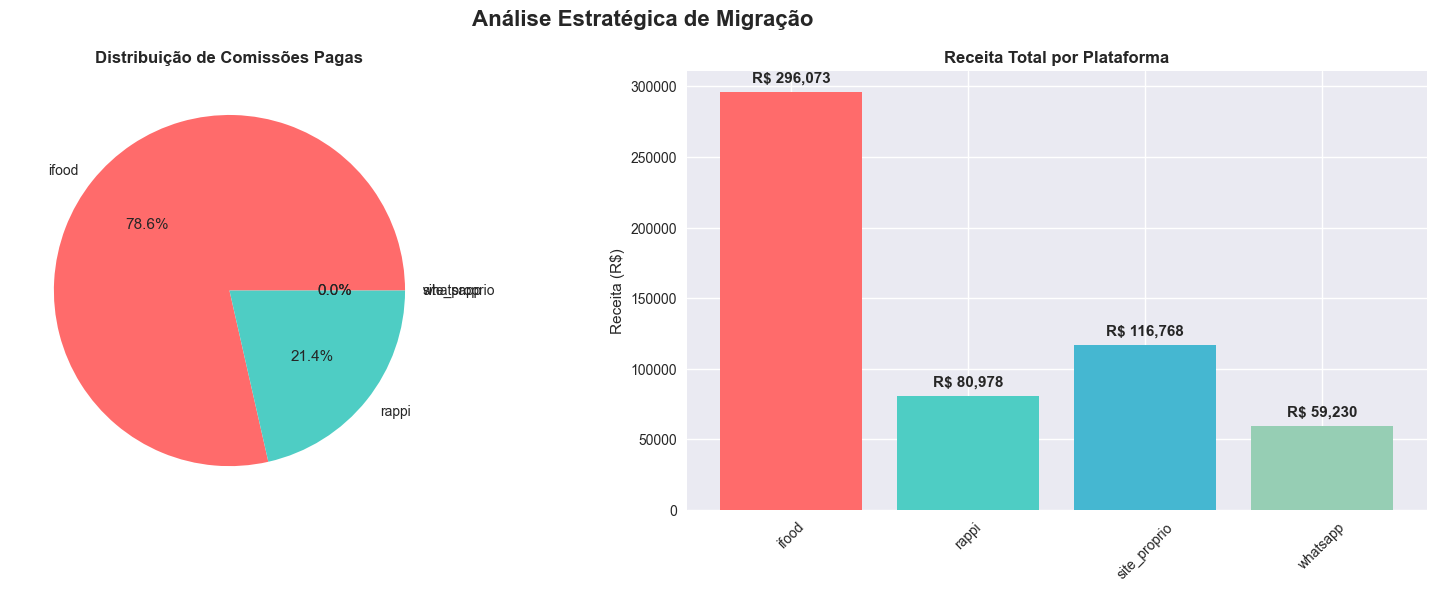

In [33]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Análise Estratégica de Migração', fontsize=16, fontweight='bold')


comissoes_plataformas = df.groupby('platform')['comissao_paga'].sum()
axes[0].pie(
    comissoes_plataformas.values,
    labels=comissoes_plataformas.index,
    autopct='%1.1f%%',
    colors=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
)
axes[0].set_title('Distribuição de Comissões Pagas', fontweight='bold')



receita_plataformas = df.groupby('platform')['total_brl'].sum()
axes[1].bar(
    receita_plataformas.index,
    receita_plataformas.values,
    color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
)
axes[1].set_title('Receita Total por Plataforma', fontweight='bold')
axes[1].set_ylabel('Receita (R$)')
axes[1].tick_params(axis='x', rotation=45)

# numerios ficam em cima das barras
for i, v in enumerate(receita_plataformas.values):
    axes[1].text(i, v + 5000, f'R$ {v:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


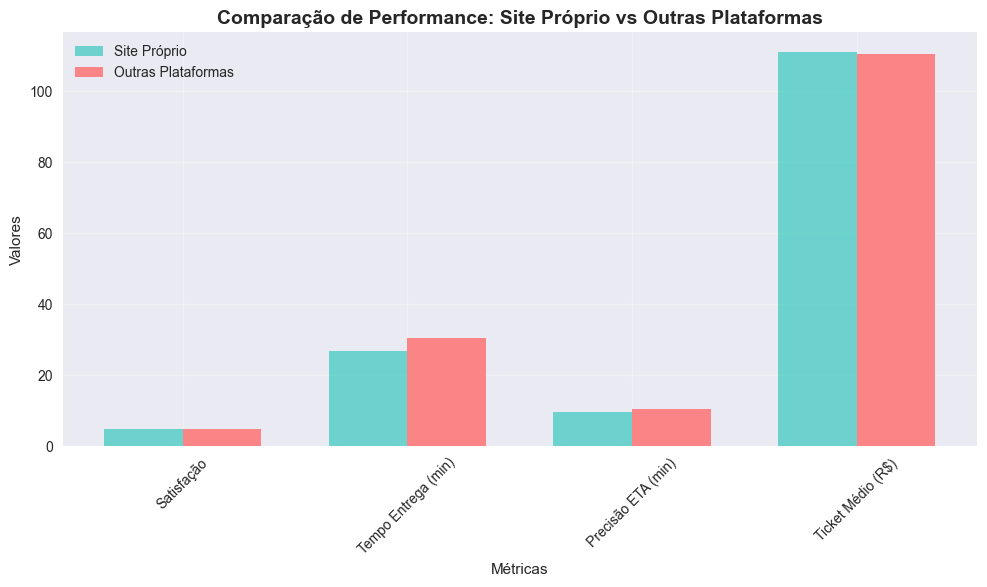

In [34]:
plt.figure(figsize=(10, 6))
plt.title('Comparação de Performance: Site Próprio vs Outras Plataformas', fontsize=14, fontweight='bold')


metricas = ['Satisfação', 'Tempo Entrega (min)', 'Precisão ETA (min)', 'Ticket Médio (R$)']
site_proprio_vals = [
    df[df['platform'] == 'site_proprio']['satisfacao_nivel'].mean(),
    df[df['platform'] == 'site_proprio']['actual_delivery_minutes'].mean(),
    df[df['platform'] == 'site_proprio']['precisao_eta'].mean(),
    df[df['platform'] == 'site_proprio']['total_brl'].mean()
]
outras_plataformas_vals = [
    df[df['platform'] != 'site_proprio']['satisfacao_nivel'].mean(),
    df[df['platform'] != 'site_proprio']['actual_delivery_minutes'].mean(),
    df[df['platform'] != 'site_proprio']['precisao_eta'].mean(),
    df[df['platform'] != 'site_proprio']['total_brl'].mean()
]

x = np.arange(len(metricas))
width = 0.35

plt.bar(x - width/2, site_proprio_vals, width, label='Site Próprio', color='#4ecdc4', alpha=0.8)
plt.bar(x + width/2, outras_plataformas_vals, width, label='Outras Plataformas', color='#ff6b6b', alpha=0.8)

plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.xticks(x, metricas, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Análise de Oportunidades de Migração por Segmento
**Objetivo:** Identificar os segmentos de clientes com maior potencial de migração.


In [37]:
print("ANÁLISE DE OPORTUNIDADES DE MIGRAÇÃO")


# Análise por classe de pedido
migracao_classe = df[df['platform'] != 'site_proprio'].groupby('classe_pedido').agg({
    'total_brl': ['count', 'sum', 'mean'],
    'satisfacao_nivel': 'mean',
    'platform_commission_pct': 'mean'
}).round(2)

print("\nOPORTUNIDADES POR CLASSE DE PEDIDO:")
print(migracao_classe)

# Análise por bairro
migracao_bairro = df[df['platform'] != 'site_proprio'].groupby('macro_bairro').agg({
    'total_brl': ['count', 'sum'],
    'satisfacao_nivel': 'mean',
    'actual_delivery_minutes': 'mean'
}).round(2)

print("\nOPORTUNIDADES POR BAIRRO")
print(migracao_bairro.sort_values(('total_brl', 'sum'), ascending=False).head(10))





ANÁLISE DE OPORTUNIDADES DE MIGRAÇÃO

OPORTUNIDADES POR CLASSE DE PEDIDO:
              total_brl                    satisfacao_nivel  \
                  count        sum    mean             mean   
classe_pedido                                                 
combo              1330  173387.53  130.37             4.62   
familia             399   93268.61  233.76             3.91   
prato_unico        2219  169624.62   76.44             4.87   

              platform_commission_pct  
                                 mean  
classe_pedido                          
combo                            0.12  
familia                          0.13  
prato_unico                      0.12  

OPORTUNIDADES POR BAIRRO
             total_brl           satisfacao_nivel actual_delivery_minutes
                 count       sum             mean                    mean
macro_bairro                                                             
Brooklin           710  77763.33             4.80          


PARTICIPAÇÃO EM HORÁRIOS DE PICO (12h-14h e 19h-20h):
Total de pedidos em pico: 2,084
Site próprio em pico: 432 (20.7%)
Outras plataformas em pico: 1,652 (79.3%)

Site próprio tem baixa participação em horários estratégicos de pico



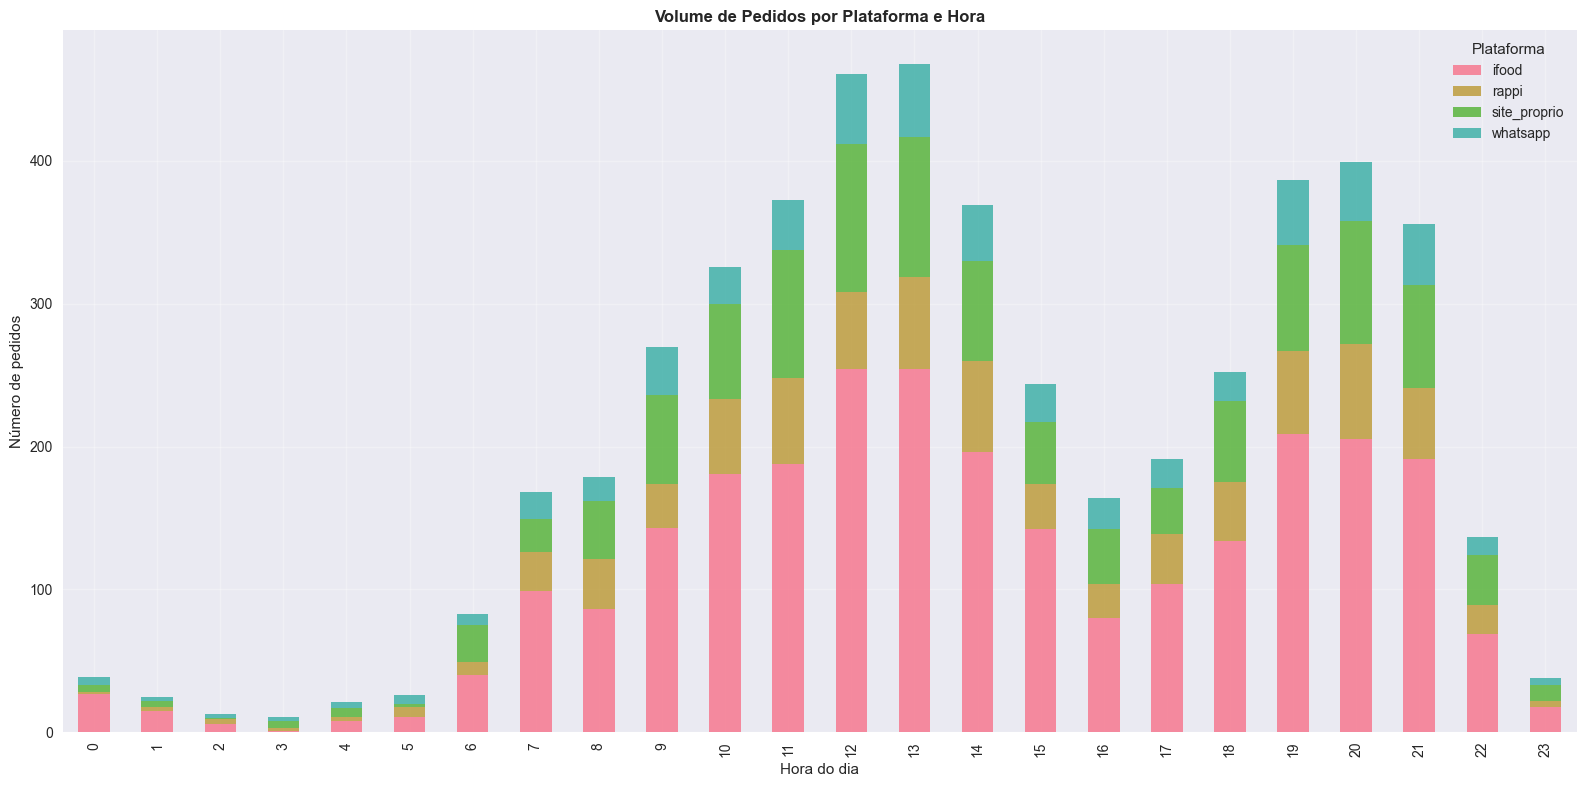


INSIGHTS:
Site próprio tem baixa participação em horários de pico
Horários estratégicos (12h-14h e 19h-20h) dominados por outras plataformas
Oportunidade de aumentar presença em horários de alto volume


In [36]:
pedidos_pico = df[df['is_pico'] == True]
site_pico = site_proprio[site_proprio['is_pico'] == True]
outras_pico = pedidos_pico[pedidos_pico['platform'] != 'site_proprio']

print(f"\nPARTICIPAÇÃO EM HORÁRIOS DE PICO (12h-14h e 19h-20h):")
print(f"Total de pedidos em pico: {len(pedidos_pico):,}")
print(f"Site próprio em pico: {len(site_pico):,} ({len(site_pico)/len(pedidos_pico)*100:.1f}%)")
print(f"Outras plataformas em pico: {len(outras_pico):,} ({len(outras_pico)/len(pedidos_pico)*100:.1f}%)")
print(f"\nSite próprio tem baixa participação em horários estratégicos de pico\n")


fig, ax = plt.subplots(figsize=(16, 8))

# Volume de pedidos por plataforma e hora
pedidos_por_hora = df.groupby(['hora', 'platform']).size().unstack(fill_value=0)
pedidos_por_hora.plot(kind='bar', stacked=True, ax=ax, alpha=0.8)

ax.set_title('Volume de Pedidos por Plataforma e Hora', fontweight='bold')
ax.set_xlabel('Hora do dia')
ax.set_ylabel('Número de pedidos')
ax.legend(title='Plataforma')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nINSIGHTS:")
print(f"Site próprio tem baixa participação em horários de pico")
print(f"Horários estratégicos (12h-14h e 19h-20h) dominados por outras plataformas")
print(f"Oportunidade de aumentar presença em horários de alto volume")
